Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import tree


### Function for precision, recall, macrof1, microf1, and f1 scores
The indices of the classes in `y_pred` and `y` start from 0 in `pre_rec_f1`, e.g., [1, 1, 0, 0, 2, 2, 2].

In [2]:
def pre_rec_f1(y_pred, y):
    eps = np.finfo(float).eps
    num_cls = len(np.unique(y))
    tp_sum, fp_sum, fn_sum, f1_sum = 0, 0, 0, 0
    tps, fps, fns, pre, rec, f1s = [], [], [], [], [], []
    for i in range(num_cls):
        y_pred_i = y_pred == i
        y_i = y == i
        tp = np.logical_and(y_pred_i, y_i).sum()
        fp = np.logical_and(y_pred_i, (~y_i)).sum()
        fn = np.logical_and((~y_pred_i), y_i).sum()
        tp_sum += tp
        fp_sum += fp
        fn_sum += fn
        f1 = (2 * tp) / (2 * tp + fp + fn + eps)
        f1_sum += f1
        pre.append(tp / (tp + fp + eps))
        rec.append(tp / (tp + fn + eps))
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        f1s.append(f1)

    macrof1 = f1_sum / (num_cls + eps)
    microf1 = (2 * tp_sum) / (2 * tp_sum + fp_sum + fn_sum + eps)
    return  {"macrof1": macrof1, "microf1": microf1, "tp": tps, "fp": fps, "fn": fns, "pre": pre, "rec": rec, "f1": f1s}

In [3]:
df = pd.read_csv('Dry_Bean_Dataset.csv')
df = df.drop(columns=['Unnamed: 0'])

X = df.drop(['Class', 'Class_String'], axis=1)
y = df['Class']

best_res = []

# Task 1

#### A. Using all attributes, build a Decision Tree model to predict bean varieties: Train the Decision Tree model using the given maximum depths (3, 7, 11, 15).

#### B. In the report, describe the values of all model parameters (such as gini/entropy criterion, min_samples_split, etc.) used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.

`model = DecisionTreeClassifier(max_depth=depth, random_state=42)`

In this experiment, we assume a default `criterion` of `gini`. The `criterion` is a function used to measure the quality of a split where `gini` is the probability of a random sample being classified correctly when selected randomly and Gini Impurity gives us the probability of misclassifying an observation. `Entropy` is a measurement of impurity or randomness in observed data points. The higher the entropy, the lower the purity and for a model, you would want to reduce the impurity. Entropy would be maximum when the probability of two classes is the same, and it is minimum when 0/when the node is pure. `log_loss` indicates how close the prediction probability is to the corresponding true value, where the higher the log-loss value, the more the predicted probability diverges from the actual value.

The `max_depth` parameter is the maximu depth of the tree. The default value is `None`, which signifies that the nodes are expanded until all leaves are pure or until all the leaves contain less than min_sample_split samples.

We also set a `random_state` value to the arbitrary value of 42 to control the randomness of the estimator used to shuffle the data before splitting it. What it does is that it ensures that the same randomization is used each time the code is run, resulting in the same splits of the data, thus allowing for consistent results during each run.

#### C. Perform 5-fold cross-validation for each of the 4 max depths and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes. Generate a table, as given below, for the obtained results.

In [4]:

max_depths = [3, 7, 11, 15]
result = []
best_model = None

kf  = KFold(n_splits= 5, shuffle=True, random_state=42)

for depth in max_depths:
    accuracies = []
    precisions = []
    recalls = []
    macrof1s = []
    microf1s = []
    for train_index, test_index in kf.split(X, y):
        x_train = X.iloc[train_index]
        x_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(x_train, y_train.values.ravel())
        y_pred = model.predict(x_test)

        cv_result = pre_rec_f1(y_pred, y_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(cv_result["pre"])
        recalls.append(cv_result["rec"])
        macrof1s.append(cv_result["macrof1"])
        microf1s.append(cv_result["microf1"])
        
    result.append([depth, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)])
    if not best_model or np.mean(accuracies) > best_model[1]:
        best_model = ["Decision Tree", np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)]
best_res.append(best_model)
pd.DataFrame(result, columns=["Max Depth", "Accuracy", "Precision", "Recall", "Macro-f1", "Micro-f1"])

,Max Depth,Accuracy,Precision,Recall,Macro-f1,Micro-f1
0,3,0.783779,0.612322,0.671304,0.627805,0.783779
1,7,0.903460,0.916293,0.910542,0.912760,0.903460
2,11,0.895746,0.910628,0.906291,0.908142,0.895746
3,15,0.891264,0.906060,0.903815,0.904764,0.891264


#### D. Explain how the tree size/depth affects model performance in the context of overfitting/underfitting.

The depth of a decision tree is the length of the longest path from a root node to a leaf node, with shallow trees having a lower depth and deep trees having a greater depth. Shallow trees are prone to underfitting since they may capture too little patterns and fail to capture important predictive relationships. This can result in lower variance but high bias, meaning that the model may not be fitting the training data well.

On the other hand, a deeper tree with more splits can result in higher variance and lower bias. Since the model complexity increases, the model may lead to poor generalization as it is modeling the noise and outliers in the data instead of learning the underlying patterns. Additionally, deeper trees often result in high accuracy on the training set but poor performance on the testing set. This is the opposite for a shallow underfitting tree, where accuracy is poor for both training and testing data.

#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.

When `max_depth = 3`, the model's accuracy, precision, and recall score was the lowest. This means that the model accurately predicted the correct bean type 78.38% of the time (accuracy), as well as correctly predicted a given target class 61.23% of the time, and was able to find all objects of the target class (recall) 67.13% of the time. The accuracy, precision, and recall values for when `max_depth = 11 and 15` were both fairly high and similar to each other. When `max_depth = 7`, accuracy, precision, and recall was the highest. Accuracy, precision, and recall may have been the lowerst when `max_depth = 3` since the tree was shallow. And when a tree is shallow, then it is prone to underfitting and may not capture enough patterns or important relationships. Accuracy ends up being poorer due to this, while for deeper trees like when `max_depth = 11, 15` accuracy is higher, though performance on the testing set is poor due overfitting.

#### F. Plot the Decision Tree with depth 3 and interpret the decision process according to the tree structure (e.g., gini/entropy gain, feature, split, class of each node, paths from root to leaf nodes, etc.)

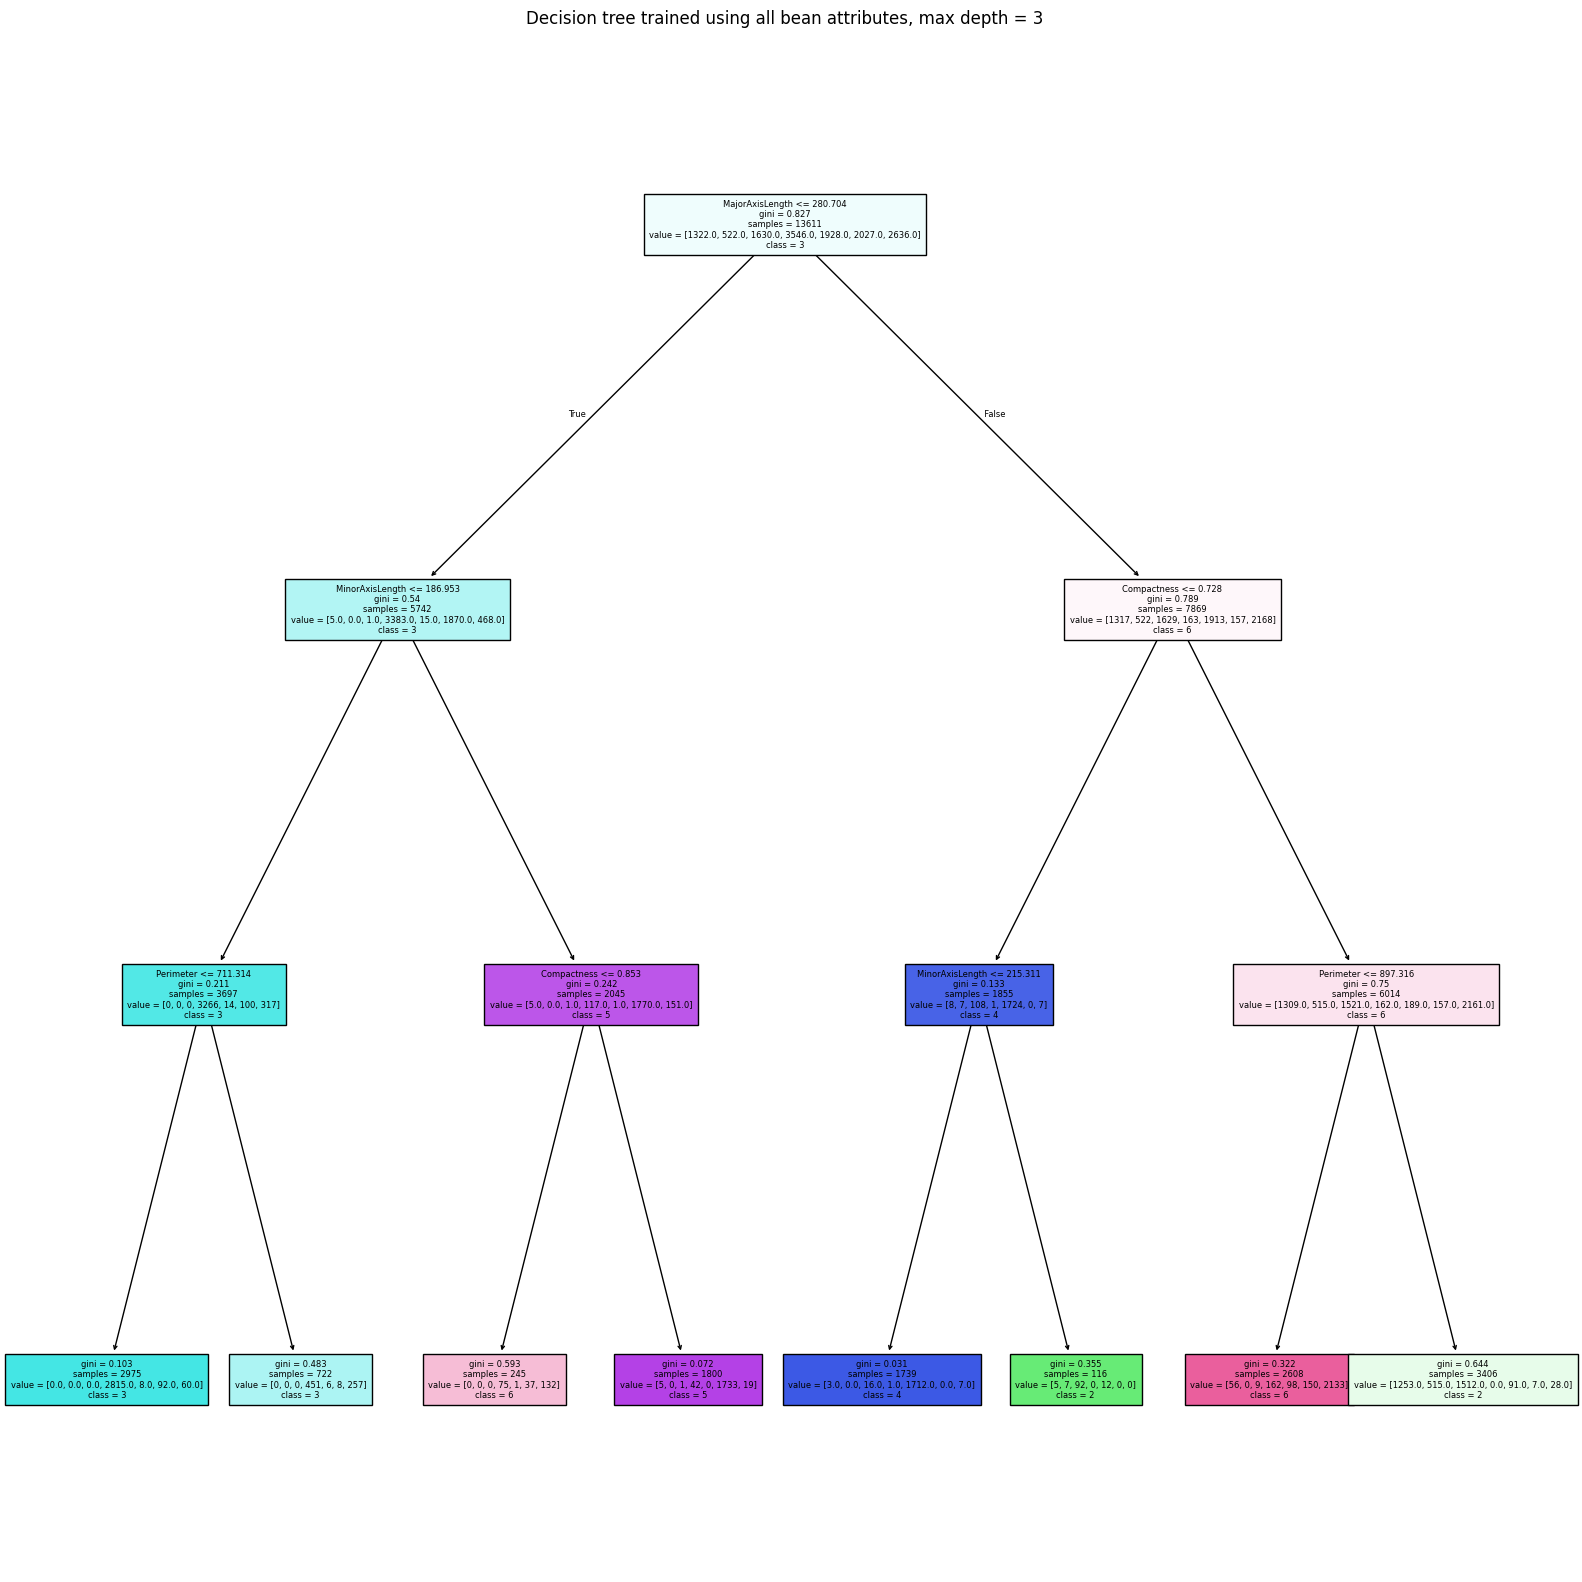

In [5]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X, y)

a = []

for i in y.unique():
    a.append(str(i))

a.sort()

plt.figure(figsize=(20,20))
tree.plot_tree(model, filled=True, fontsize=6, feature_names=X.columns, class_names=a)
plt.title("Decision tree trained using all bean attributes, max depth = 3")
plt.show()

At the root node, there were 13611 samples and the gini ratio was 0.827, meaning that most elements belonged to a certain class. There were 1322, 522, 1630, 3546, 1928, 2027, and 2636 data points in bean categories 0-6 respectively. The predicted bean type for a data point that reached this leaf would be class 3 or Dermosasn. 

If MajorAxisLength is less than or equal to 280.704, then the gini ratio is 0.52 meaning the elements were distributed fairly equally into some classes. 5742 data points reached this node with 5, 0, 1, 3383, 15, 1870, 468 were in bean categories 0-6 respectively, with the overall prediction being class 3 or Dermosan. If the MinorAxisLength was less than or equal to 186.953 then the gini index was 0.211 indicating the data points were distributed mostly to the same class. The overall prediction is class 3/Dermosan. Then if Perimeter is less than or equal to 711.314 then the gini ratio is 0.103 and the overall prediced bean type would again be class 3/Dermosan.

If Perimeter was greater than 711.314 then the gini index would be 0.483 and the predicted bean type would be class 3/Dermosan again. If MinorAxisLength was greater than 186.953 then the gini index is 0.242, and the predicted bean type is class 5/Seker. Then if Compactness is less than or equal to 0.853 then gini is 0.593 and the predicted bean type is class 6/Sira. If greater then it's gini would be 0.072 with a predicted bean type of class 5/Seker.


If MajorAxisLength was greater than 280.704, then its gini would be 0.789, with 7689 data points reaching the next node with a predicted bean type of class 6/Sira. Then if Compactness was less than or equal to 0.728 then its gini would be 0.133 with a predicted bean type of class 4/Horoz. Moving on to the next node, if MinorAxisLength was less than or greater than 215.311 then its gini would be 0.031 with a predicted bean type of class 4/Horoz. If not, then it's gini would be 0.355 with a predicted bean type of class 2/Cali. If Compactness was greater than 0.728, then its gini is 0.75 with a predicted bean type of class 6/Sira. Then if its perimeter were less than or equal to 897.316 then its gini is 0.322 with a predicted bean type of class 6/Sira. If not, then its gini is 0.644 with a predicted bean type of class 2/Cali. 

A gini value of 0 denotes that all elements belong to a certain class or that only one class exists, and that node is pure. If it is 1 then all elements are randomly distributed across the different classes and is thus impure. A value of 0.5 denotes an equal distribution of the elements among the classes.

# Task 2

#### A. Using all attributes, build a K-NN classifier to predict bean varieties: Train the K-NN using the given neighbors (3, 9, 17, 25).


#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.

```KNeighborsClassifier(n_neighbors=neighbor)```

For this experiment, `n_neighbors` refers to the number of neighbors to use, with the default value being 5. 

Other default parameters include `weights` (default = uniform) which refers to the use of uniform weights used in the weight function in prediction. This means that all points in each neighborhood are weighted equally. `Algorithm` (default = auto) means that to compute the nearest neighbors, the model will attempt to decide the most appropriate algorithm based on the values passed to fit method. `leaf_size` (default = 30) is the leaf size passed to BallTree or KDTree, which can affect speed and memory use. `p` (default = 2) is the power parameter for the Minkowski metric. `metric` (default = minkowski) is the metric to use for distance computation. `metric_params` (default = None) are just additional keyword arguments for `metric`and `n_jobs` (default = None) is the number of parallel jobs to run for neighbors search, where None means 1 and -1 means all processors.

#### C. Perform 5-fold cross-validation for each of the 4 neighbor size and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes. Generate a table, as given below, for the obtained results.

In [6]:
neighbors = [3, 9, 17, 25]
result = []
best_model = None

kf  = KFold(n_splits= 5, shuffle=True, random_state=42)

for neighbor in neighbors:
    accuracies = []
    precisions = []
    recalls = []
    macrof1s = []
    microf1s = []
    for train_index, test_index in kf.split(X, y):
        x_train = X.iloc[train_index]
        x_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_test = sc.transform(x_test)

        model = KNeighborsClassifier(n_neighbors=neighbor)
        model.fit(x_train, y_train.values.ravel())
        y_pred = model.predict(x_test)


        cv_result = pre_rec_f1(y_pred, y_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(cv_result["pre"])
        recalls.append(cv_result["rec"])
        macrof1s.append(cv_result["macrof1"])
        microf1s.append(cv_result["microf1"])

    result.append([neighbor, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)])
    if not best_model or np.mean(accuracies) > best_model[1]:
        best_model = ["K-NN", np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)]
best_res.append(best_model)
pd.DataFrame(result, columns=["Neighbors", "Accuracy", "Precision", "Recall", "Macro-f1", "Micro-f1"])

,Neighbors,Accuracy,Precision,Recall,Macro-f1,Micro-f1
0,3,0.909852,0.923065,0.921020,0.921878,0.909852
1,9,0.916538,0.930591,0.926845,0.928423,0.916538
2,17,0.919256,0.933606,0.928492,0.930553,0.919256
3,25,0.919183,0.932821,0.927671,0.929774,0.919183


#### D. Explain how the number of neighbors affects model performance in the context of overfitting/underfitting.

The K-nearest neighbors of a record x are the data points that have the k smallest distance to x. If k/the number of neighbors is too small then it is sensitive to noise points. If k is too high, then the neighborhood may include points from other classes.

Lower k values also tend to lead to high variance and low bias as any noise will have a higher influence on the result and have unstable decision boundaries. The model is more sensitive to these local anomalies as it gives more weight to these points, leading to overfitting. Having too large of a value of k would result in underfitting as the model is too simple to capture the underlying patterns. The model is too generalized and the data patterns are oversimplified.

### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.

There is no significant difference in accuracy, precision, and recall scores among the different k-neighbors.

# Task 3

#### A. Using all attributes, build an SVM Model to predict bean varieties: Train the SVM model using the given kernel functions (linear, polynomial, rbf, sigmoid).

#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.

In this experiment, our included parameters include `kernel` and `random_state`. `kernel` specifies the kernel type to be used in the algorithm and has a default value of `rbf`. 

We also set a `random_state` value to the arbitrary value of 42 to control the randomness of the estimator used to shuffle the data before splitting it. What it does is that it ensures that the same randomization is used each time the code is run, resulting in the same splits of the data, thus allowing for consistent results during each run.

#### C. Perform 5-fold cross-validation for each of the 4 kernel functions and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes. Generate a table, as given below, for the obtained results.

In [7]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
result = []
best_model = None

kf  = KFold(n_splits= 5, shuffle=True, random_state=42)

for kernel in kernels:
    accuracies = []
    precisions = []
    recalls = []
    macrof1s = []
    microf1s = []
    for train_index, test_index in kf.split(X, y):
        x_train = X.iloc[train_index]
        x_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_test = sc.transform(x_test)

        svm = SVC(kernel=kernel, random_state=42)
        svm.fit(x_train, y_train.values.ravel())
        y_pred = svm.predict(x_test)


        cv_result = pre_rec_f1(y_pred, y_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(cv_result["pre"])
        recalls.append(cv_result["rec"])
        macrof1s.append(cv_result["macrof1"])
        microf1s.append(cv_result["microf1"])

    result.append([kernel, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)])
    if not best_model or np.mean(accuracies) > best_model[1]:
        best_model = ["SVM", np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)]
best_res.append(best_model)
pd.DataFrame(result, columns=["Kernel Functions", "Accuracy", "Precision", "Recall", "Macro-f1", "Micro-f1"])

,Kernel Functions,Accuracy,Precision,Recall,Macro-f1,Micro-f1
0,linear,0.917787,0.930524,0.927561,0.928832,0.917787
1,poly,0.903166,0.929529,0.909217,0.916673,0.903166
2,rbf,0.922783,0.936199,0.931620,0.933589,0.922783
3,sigmoid,0.737272,0.667374,0.630317,0.645899,0.737272


#### D. Discuss the impact of different kernels on model performance.

The `linear` kernel is the simplest kernel function as it is usually one dimensional. It is the dot product of the input samples where it is then applied to any combination of two data points in the dataset. It does not perform any transformations on the data and is thus easier to implement and is faster. Linear kernels often result in an untransformed feature space, where the hyperplane and the margins are straight lines, and thus lack of expressitivity of the data and the trained classes not capturing the training data perfectly. Or in other words, it may not capture the complesity of the data and by adding more features, this can result in overfitting. It is good for straight-line separable data but not so good for curves.

`polynomial` is a more generalized and flexible representation of the linear kernel that adds curves to linear separation and transforms data into higher dimensions and fitting non-linear boundaries. It can handle more complex data by making curves but is less efficient and accurate and can lead to overfitting. It is suitable for low-dimensional and dense data, and adding more features can improve performance and accuracy.

The`rbf` kernel measures the similarity between two points in indefinite dimensions and classifies using a majority vote. It is flexible and can model non-linear and complex relationships and shapes by creating smooth decision boundaries. Choosing a small gamma value may overfit the data, and too large of a value can overgeneralize the data. It is best used with medium-dimensional data. It is the most popular and widely used kernel function for SVMs. 

`sigmoid` is preferred for neural networks and works well for data with no clear shapes/non-linear data and uses a hyperbolic tangent function. It can model non-linear and sigmoidal relationships and is best used for binary and categorical data. However it is sensitive to the alpha and beta parameters and may not perform as well as RBF. It is also sensitive to scaling.


#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.

The accuracy, precision, and recall scores for when the kernel function was `linear`, `polynomial`, and `rbf` were all fairly high and similar. However, the scores for when the kernel function was `sigmoid` was the lowest with the classifier making correct bean type predictions only 73.73% of the time, having a proportion of true positive bean type predictions among all positive predictions only 66.74% of the time, and being able to find all objects of the target class only 63.03% of the time. This could be due to the fact that sigmoid requires more parameter tuning to optimize performance. In general both linear and rbf perform well. Linear is less prone to overfitting when the number of samples is large and faster to train and predict. Polynomial can capture interactions between fitting and may lead to overfitting with smaller datasets. And rbf in general is very flexible and can handle a wide variety of data distributions.

Sigmoid can lead to convergence issues during training, resulting in lower metrics like above as it is difficult to have positive parameters.

# Task 4

#### A. Using all attributes, build a Gradient Boosting Classifier to predict bean varieties: Train the Gradient Boosting Classifier using the given number of estimators (3, 5, 10, 100).

#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.

In this experiment, the parameters used include `n_estimators` and `random_state`. 

`n_estimators` is the number of predictors that we want the GBM to build/ the number of boosted trees to fit or the number of boosting rounds. The default value is 100.

We also set a `random_state` value to the arbitrary value of 42 to control the randomness of the estimator used to shuffle the data before splitting it. What it does is that it ensures that the same randomization is used each time the code is run, resulting in the same splits of the data, thus allowing for consistent results during each run.

#### C. Perform 5-fold cross-validation for each of the 4 kernel functions and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes. Generate a table, as given below, for the obtained results.

In [8]:
estimators = [3, 5, 10, 100]
result = []
best_model = None

kf  = KFold(n_splits= 5, shuffle=True, random_state=42)

for estimator in estimators:
    accuracies = []
    precisions = []
    recalls = []
    macrof1s = []
    microf1s = []
    for train_index, test_index in kf.split(X, y):
        x_train = X.iloc[train_index]
        x_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_test = sc.transform(x_test)

        model = LGBMClassifier(n_estimators=estimator, random_state=42)
        model.fit(x_train, y_train.values.ravel())
        y_pred = model.predict(x_test)

        cv_result = pre_rec_f1(y_pred, y_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(cv_result["pre"])
        recalls.append(cv_result["rec"])
        macrof1s.append(cv_result["macrof1"])
        microf1s.append(cv_result["microf1"])


    result.append([estimator, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)])
    if not best_model or np.mean(accuracies) > best_model[1]:
        best_model = ["Gradient Boosting Classifier", np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(macrof1s), np.mean(microf1s)]
best_res.append(best_model)
pd.DataFrame(result, columns=["Estimators", "Accuracy", "Precision", "Recall", "Macro-f1", "Micro-f1"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 10888, number of used features: 12
[LightGBM] [Info] Start training from score -2.328449
[LightGBM] [Info] Start training from score -3.291529
[LightGBM] [Info] Start training from score -2.115347
[LightGBM] [Info] Start training from score -1.331609
[LightGBM] [Info] Start training from score -1.968951
[LightGBM] [Info] Start training from score -1.908946
[LightGBM] [Info] Start training from score -1.645724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 1088

,Estimators,Accuracy,Precision,Recall,Macro-f1,Micro-f1
0,3,0.908971,0.928021,0.914141,0.920239,0.908971
1,5,0.915656,0.929559,0.922451,0.925604,0.915656
2,10,0.919110,0.931282,0.926812,0.928809,0.919110
3,100,0.916979,0.930417,0.926694,0.928408,0.916979


#### D. Discuss the impact of different numbers of estimators on model performance in the context of ensemble models.

In terms of the number of estimators, the more trees you build the stronger and more complex the ensemble becomes as more trees allow the model to capture more patterns in the data. This however can increae the chance of overfitting. On the other hand a higher number of estimators can be more computationally intensive and decrease the model's accuracy.

#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.

There is no significant difference in accuracy, precision, and recall scores among the different number of estimators.

# Task 5

#### A. Interpret the tables you generated in questions 1C, 2C, 3C, 4C by generating a table, as given below, for comparing the best performance of the Decision Tree, K-NN, SVM and Gradient Boosting Classifier models (i.e., put each mode's best performance from the above tables to the following table). Which model performs better? Why do you think that is the case?

In [9]:
pd.DataFrame(best_res, columns=["Methods", "Accuracy", "Precision", "Recall", "Macro-f1", "Micro-f1"])

,Methods,Accuracy,Precision,Recall,Macro-f1,Micro-f1
0,Decision Tree,0.903460,0.916293,0.910542,0.912760,0.903460
1,K-NN,0.919256,0.933606,0.928492,0.930553,0.919256
2,SVM,0.922783,0.936199,0.931620,0.933589,0.922783
3,Gradient Boosting Classifier,0.919110,0.931282,0.926812,0.928809,0.919110


Overall, the SVM model performed the best, though it was marginally better. This may be due to the fact that SVMs can support both linear and non-linear solutions using the kernel method, and handles outliers well. KNN is also slow in real time as it has to keep track of all the training data and has to find the neighbor nodes. Decision Trees and KNN are also both non-parametric meaning that the model does not have an assumption on the distribution of the data. On the other hand, while KNN is simple and makes decisions based on the neighbor data points and Gradient Boosting Classifier is an ensemble method and combines multiple decision trees to make predictions, it does not work well on high-dimensional data. 

SVM povides the highest classification accuracy and is very adaptable and effective in high-dimension spaces. Additionally, in comparison to kNN, while kNN will generally classify accurately most of the time; it may generate several small misclassifications that may interfere with the final results. And in comparison, SVM will occasionally misclassify a large object that rarely interfere with the final image.